<a href="https://colab.research.google.com/github/Droslj/scATAC-seq-complete-/blob/Google-colab/scATAC_seq_(2)_DA_diffxpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

scATAC seq, based on scATAC seq processing Galaxy tutorials (scATAC preprocessing (2), Standard scATAC seq processing pipeline (1) )
AD Objects created in Galaxy using customized Galaxy WF with Snapatac2 and imported
(1) https://usegalaxy.eu/training-material/topics/single-cell/tutorials/scatac-preprocessing-tenx/tutorial.html#mapping-reads-to-a-reference-genome, (2) https://usegalaxy.eu/training-material/topics/single-cell/tutorials/scatac-standard-processing-snapatac2/tutorial.html
Data taken from the following NCBI study:
Metabolic adaptation pilots the differentiation of human hematopoietic cells (https://www.ncbi.nlm.nih.gov/bioproject/PRJNA1015713)
Import Anndata objects for two biological replicates, SRR26046013 (cells treated with AOA inhibitor) and SRR26046019 (untreated cells)
Perform following steps:
(1) Import matrices
(2) Compute fragment size distribution
(3) Compute TSS enrichment
(4) Filter cell counts based on TSSe
(5) Create cell by bin matrix based on 500 bp wide bins accross the whole genome
(6) Perform feature selection
(7) Perform Doublet removal
(8) Perform Dim reduction (spectral)
(9) Perform Clustering (neighborhood, UMAP, leiden)
(10) Create a cell by gene matrix
(11) Concatenate matrices using Inner join
(12) Remove batch effects

In [1]:
!pip install -q condacolab

In [2]:
import condacolab

In [3]:
condacolab.install()

✨🍰✨ Everything looks OK!


In [4]:
!conda --version

conda 23.11.0


In [5]:
!which conda

/usr/local/bin/conda


In [6]:
!conda config --add channels conda-forge

In [7]:
!conda config --add channels bioconda

In [8]:
!pip install snapatac2 -q

In [9]:
!pip show snapatac2

Name: snapatac2
Version: 2.8.0
Summary: SnapATAC2: Single-cell epigenomics analysis pipeline
Home-page: https://github.com/
Author: Kai Zhang <kai@kzhang.org>
Author-email: Kai Zhang <zhangkai33@westlake.edu.cn>
License: MIT
Location: /usr/local/lib/python3.10/site-packages
Requires: anndata, igraph, kaleido, macs3, multiprocess, natsort, numpy, pandas, plotly, polars, pooch, pyarrow, pyfaidx, rustworkx, scikit-learn, scipy, tqdm, typeguard
Required-by: 


In [10]:
import snapatac2 as snap

In [11]:
!pip install umap-learn



In [12]:
import umap.umap_ as umap


In [13]:
from umap import UMAP

In [14]:
!pip install scanpy -q

In [15]:
import scanpy as sc

In [16]:
pip show scanpy

Name: scanpy
Version: 1.10.4
Summary: Single-Cell Analysis in Python.
Home-page: 
Author: Alex Wolf, Philipp Angerer, Fidel Ramirez, Isaac Virshup, Sergei Rybakov, Gokcen Eraslan, Tom White, Malte Luecken, Davide Cittaro, Tobias Callies, Marius Lange, Andrés R. Muñoz-Rojas
Author-email: 
License: 
Location: /usr/local/lib/python3.10/site-packages
Requires: anndata, h5py, joblib, legacy-api-wrap, matplotlib, natsort, networkx, numba, numpy, packaging, pandas, patsy, pynndescent, scikit-learn, scipy, seaborn, session-info, statsmodels, tqdm, umap-learn
Required-by: 


In [17]:
import numpy as np

In [18]:
import anndata as ad

In [19]:
!pip install diffxpy -q

In [20]:
!pip install --user scikit-misc -q

In [21]:
import diffxpy.api as de

In [22]:
import matplotlib.pyplot as plt

In [23]:
import seaborn as sns

In [24]:
import plotly.subplots as sp
import plotly.graph_objects as go

In [25]:
from scipy import stats

In [26]:
import pandas as pd

# Import reads from google drive, three samples treated with energy metabolism inhibitors and one untreated

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
#Load AD matrix from google drive, PCA and Batch corrected
adata_concat = sc.read_h5ad('/content/drive/MyDrive/Colab Notebooks/MTXmerged_PCA_BC.h5ad')

/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


# Make observation names unique



In [29]:
adata_concat

AnnData object with n_obs × n_vars = 21361 × 53017
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden', 'Treatment'
    uns: 'pca'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'

In [30]:
# Check if any gene names are duplicated
has_duplicates = adata_concat.var_names.duplicated().any()

if has_duplicates:
    print("var_names are not unique.")
else:
    print("var_names are unique.")

var_names are unique.


In [31]:
# Check if the number of unique gene names is equal to the total number of gene names
is_unique = len(adata_concat.var_names) == pd.Series(adata_concat.var_names).nunique()

if is_unique:
    print("var_names are unique.")
else:
    print("var_names are not unique.")

var_names are unique.


In [32]:
# Check if any observations are duplicated
has_duplicates = adata_concat.obs_names.duplicated().any()

if has_duplicates:
    print("Observations are not unique.")
else:
    print("Observations are unique.")

Observations are not unique.


In [33]:
# Check if the number of unique observations is equal to the total number of observations
is_unique = len(adata_concat.obs_names) == pd.Series(adata_concat.obs_names).nunique()

if is_unique:
    print("Observations are unique.")
else:
    print("Observations are not unique.")

Observations are not unique.


In [34]:
adata_concat.var_names

Index(['DDX11L1', 'WASH7P', 'ENSG00000238009', 'ENSG00000239945', 'DDX11L17',
       'WASH9P', 'ENSG00000228463', 'ENSG00000286448', 'U6', 'ENSG00000230021',
       ...
       'MT-ND4', 'MT-TH', 'MT-TS2', 'MT-TL2', 'MT-ND5', 'MT-ND6', 'MT-TE',
       'MT-CYB', 'MT-TT', 'MT-TP'],
      dtype='object', length=53017)

In [35]:
#Create unique observation names
experiment_names = ["Treated w/AOA", "Treated w/DON", "Treated w/DG", "Untreated"]

# Create a new column to store combined barcode and treatment information
adata_concat.obs['barcode_treatment'] = adata_concat.obs_names.astype(str)

# Modify the 'barcode_treatment' column
for i, treatment in enumerate(experiment_names):
    cell_indices = adata_concat.obs.index[adata_concat.obs["Treatment"] == treatment]
    adata_concat.obs.loc[cell_indices, 'barcode_treatment'] = adata_concat.obs.loc[cell_indices, 'barcode_treatment'] + "_" + str(i + 1)

In [36]:
#Set 'barcode_treatment' as the new index:
adata_concat.obs_names = pd.Index(adata_concat.obs['barcode_treatment'])

In [37]:
adata_concat.obs

,n_fragment,frac_dup,frac_mito,tsse,doublet_probability,doublet_score,leiden,Treatment,barcode_treatment
barcode_treatment,,,,,,,,,
AAACAACGAACGAGCA_1,20919,0.502426,0.000096,25.061425,0.052336,0.047059,7,Treated w/AOA,AAACAACGAACGAGCA_1
AAACAACGAAGAGGCT_1,13308,0.488184,0.000826,23.198793,0.066163,0.009174,4,Treated w/AOA,AAACAACGAAGAGGCT_1
AAACAACGAAGTCGGA_1,17302,0.502830,0.000058,18.234291,0.061446,0.015294,5,Treated w/AOA,AAACAACGAAGTCGGA_1
AAACAACGAGAAGGCT_1,14109,0.530246,0.000071,29.930591,0.070621,0.004525,0,Treated w/AOA,AAACAACGAGAAGGCT_1
AAACAACGAGTACGTT_1,12165,0.588867,0.000000,21.409091,0.062457,0.013841,7,Treated w/AOA,AAACAACGAGTACGTT_1
...,...,...,...,...,...,...,...,...,...
TTTGGGATGAACGTAA_4,33918,0.336626,0.001766,18.594706,0.185808,0.043189,1,Untreated,TTTGGGATGAACGTAA_4
TTTGGGATGAAGTCTC_4,25630,0.307834,0.000117,15.581623,0.221046,0.025360,7,Untreated,TTTGGGATGAAGTCTC_4
TTTGGGATGATGTGGG_4,28438,0.336774,0.001019,19.425019,0.189493,0.040388,0,Untreated,TTTGGGATGATGTGGG_4


# Differential accessibility analysis using diffxpy

In [38]:
#numpy type aliases
np.float = float
np.int = int   #module 'numpy' has no attribute 'int'
np.object = object    #module 'numpy' has no attribute 'object'
np.bool = bool    #module 'numpy' has no attribute 'bool'

In [39]:
import dask.array as da

In [40]:
import scipy.sparse as sparse

In [41]:
adata_concat

AnnData object with n_obs × n_vars = 21361 × 53017
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden', 'Treatment', 'barcode_treatment'
    uns: 'pca'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'

# Run diffxpy wald test

In [50]:
# Calculate highly variable features
sc.pp.highly_variable_genes(adata_concat, flavor='seurat_v3')

/usr/local/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [51]:
adata_concat.var

,highly_variable,means,dispersions,dispersions_norm,highly_variable_rank,variances,variances_norm
DDX11L1,False,0.002269,-6.484691,-1.084384,NaN,0.000003,0.816448
WASH7P,False,0.005622,-6.147649,-0.743897,NaN,0.000012,0.763240
ENSG00000238009,False,0.004414,-6.010874,-0.605724,NaN,0.000011,0.999095
ENSG00000239945,False,0.002132,-6.313170,-0.911110,NaN,0.000004,0.994304
DDX11L17,False,0.010621,-5.558206,-0.148428,NaN,0.000040,0.904437
...,...,...,...,...,...,...,...
MT-ND6,True,0.940907,5.174172,1.608864,56.0,0.802492,20.113497
MT-TE,True,0.833088,4.902095,3.318027,45.0,0.726758,21.556057
MT-CYB,True,1.120541,5.500496,1.140987,64.0,0.910755,18.256744
MT-TT,True,0.891921,4.948341,1.186624,54.0,0.755453,20.361468


In [44]:
adata_concat

AnnData object with n_obs × n_vars = 21361 × 53017
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden', 'Treatment', 'barcode_treatment'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'hvg'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'

In [45]:
!pip install dask==2024.12.0 --force-reinstall -q

In [46]:
import dask.array as da

In [52]:
!pip index versions dask

dask (2024.12.1)
Available versions: 2024.12.1, 2024.12.0, 2024.11.2, 2024.11.1, 2024.10.0, 2024.9.1, 2024.9.0, 2024.8.2, 2024.8.1, 2024.8.0, 2024.7.1, 2024.7.0, 2024.6.2, 2024.6.1, 2024.6.0, 2024.5.2, 2024.5.1, 2024.5.0, 2024.4.2, 2024.4.1, 2024.4.0, 2024.3.1, 2024.3.0, 2024.2.1, 2024.2.0, 2024.1.1, 2024.1.0, 2023.12.1, 2023.12.0, 2023.11.0, 2023.10.1, 2023.10.0, 2023.9.3, 2023.9.2, 2023.9.1, 2023.9.0, 2023.8.1, 2023.8.0, 2023.7.1, 2023.7.0, 2023.6.1, 2023.6.0, 2023.5.1, 2023.5.0, 2023.4.1, 2023.4.0, 2023.3.2, 2023.3.1, 2023.3.0, 2023.2.1, 2023.2.0, 2023.1.1, 2023.1.0, 2022.12.1, 2022.12.0, 2022.11.1, 2022.11.0, 2022.10.2, 2022.10.0, 2022.9.2, 2022.9.1, 2022.9.0, 2022.8.1, 2022.8.0, 2022.7.1, 2022.7.0, 2022.6.1, 2022.6.0, 2022.5.2, 2022.5.1, 2022.5.0, 2022.4.2, 2022.4.1, 2022.4.0, 2022.3.0, 2022.2.1, 2022.2.0, 2022.1.1, 2022.1.0, 2021.12.0, 2021.11.2, 2021.11.1, 2021.11.0, 2021.10.0, 2021.9.1, 2021.9.0, 2021.8.1, 2021.8.0, 2021.7.2, 2021.7.1, 2021.7.0, 2021.6.2, 2021.6.1, 2021.6.0, 20

In [53]:
pip show dask

Name: dask
Version: 2024.12.0
Summary: Parallel PyData with Task Scheduling
Home-page: 
Author: 
Author-email: 
License: BSD-3-Clause
Location: /usr/local/lib/python3.10/site-packages
Requires: click, cloudpickle, fsspec, importlib_metadata, packaging, partd, pyyaml, toolz
Required-by: batchglm


In [54]:
# Sort genes by 'highly_variable_rank' in ascending order (lower rank = more variable)
adata_concat.var = adata_concat.var.sort_values(by='highly_variable_rank')

adata_concat.var

,highly_variable,means,dispersions,dispersions_norm,highly_variable_rank,variances,variances_norm
MTATP8P1,True,0.011273,-1.407573,4.044634,0.0,0.002180,44.267829
ENSG00000277999,True,0.006128,-1.919678,3.527294,1.0,0.000771,43.033003
ENSG00000289137,True,0.013830,-1.318055,4.135067,2.0,0.002676,38.287954
ENSG00000253817,True,0.013364,-1.298244,4.155081,3.0,0.002521,38.270587
MTND2P28,True,0.017319,-1.246181,4.207676,4.0,0.003883,37.825506
...,...,...,...,...,...,...,...
RBMY2FP,False,0.001672,-5.867844,-0.461232,NaN,0.000005,1.662601
PPP1R12BP1,False,0.005898,-6.180099,-0.776679,NaN,0.000012,0.717785
ANKRD36P1,False,0.001843,-6.458218,-1.057640,NaN,0.000003,0.896892
TPTE2P4,False,0.007077,-5.441989,-0.031024,NaN,0.000030,1.339171


In [55]:
# Subsample features (e.g., top 1000 highly variable genes)
adata_subset = adata_concat[:, adata_concat.var.index[:1000]] # Select the top 1000 genes

adata_subset.var

,highly_variable,means,dispersions,dispersions_norm,highly_variable_rank,variances,variances_norm
MTATP8P1,True,0.011273,-1.407573,4.044634,0.0,0.002180,44.267829
ENSG00000277999,True,0.006128,-1.919678,3.527294,1.0,0.000771,43.033003
ENSG00000289137,True,0.013830,-1.318055,4.135067,2.0,0.002676,38.287954
ENSG00000253817,True,0.013364,-1.298244,4.155081,3.0,0.002521,38.270587
MTND2P28,True,0.017319,-1.246181,4.207676,4.0,0.003883,37.825506
...,...,...,...,...,...,...,...
NKX2-3,True,0.401552,-1.830747,2.331799,995.0,0.040880,3.766288
CCR1,True,0.095955,-2.169804,3.274611,996.0,0.006253,3.765267
ENSG00000267610,True,0.130499,-2.402310,1.826254,997.0,0.009752,3.764141
ENSG00000233397,True,0.017788,-3.629186,1.800311,998.0,0.000404,3.763703


In [58]:
#Perform t-test
test_tt = de.test.t_test(
    data=adata_subset,
    grouping="Treatment"
)

In [64]:
test_tt.summary()

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance
0,MTATP8P1,1.860436e-186,2.238792e-186,0.724020,0.002121,False,False
1,ENSG00000277999,0.000000e+00,0.000000e+00,1.022222,0.005669,False,False
2,ENSG00000289137,6.656099e-147,7.721692e-147,0.688174,0.004294,False,False
3,ENSG00000253817,4.139208e-02,4.185246e-02,0.059771,0.002004,False,False
4,MTND2P28,0.000000e+00,0.000000e+00,1.211965,0.008803,False,False
...,...,...,...,...,...,...,...
995,NKX2-3,0.000000e+00,0.000000e+00,0.603802,0.399829,False,False
996,CCR1,0.000000e+00,0.000000e+00,0.625423,0.111940,False,False
997,ENSG00000267610,0.000000e+00,0.000000e+00,0.623364,0.109222,False,False
998,ENSG00000233397,0.000000e+00,0.000000e+00,0.673937,0.582492,False,False


<Axes: >

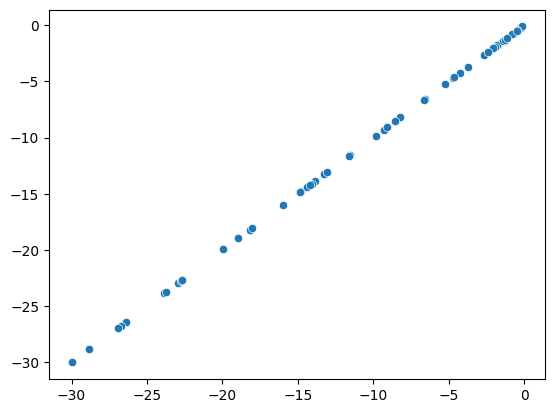

In [65]:
sns.scatterplot(
    x=test_tt.log10_pval_clean(),
    y=test_tt.log10_pval_clean()
)

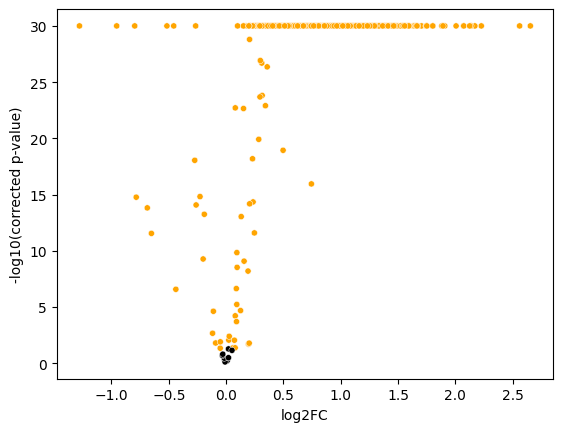

In [66]:
test_tt.plot_volcano()

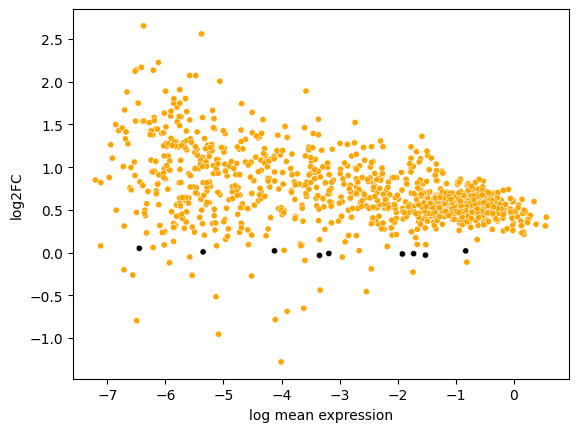

In [67]:
test_tt.plot_ma()